In [77]:
###
# The script provides APIs to perform a quick regression analysis with consumption year and postcode as
# categories variables and postcode energy use intensity (EUI: kWh/m3) as a dependent variable.
# The residual distribution of the regression fitting can be used as an indicator to estimate possible EUI variability
# of the simulated EUI
###

import os
import math
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from scipy.stats import norm


class Config:
    def __init__(self):
        cwd = os.getcwd()
        self.cwdPath = cwd
        self.measurementFilePath = cwd + '/input/pc6_measurements.csv'
        self.simulationResultsPath = cwd + '/input/simulationOutputs/AOI_all/'
        self.visualizationsPath = cwd + '/visualizations/'
        self.filePrefix = "AOI_all_semantic_"
        self.k = 2
        self.gridSize = 5
        self.caseNum = self.gridSize ** self.k
        self.trainingYears = ['2010', '2011', '2012', '2013', '2014', '2015']
        self.pTmin = np.linspace(15.0, 20.0, num=self.gridSize)  # define the key uncertain input ranges
        self.pNinf = np.linspace(0.19, 0.81, num=self.gridSize)  # define the key uncertain input ranges
        self.std = 0.068 # can be updated when the residual analysis is done


class Postcode:
    def __init__(self, postcode):
        self.postcode = postcode
        self.postcodeStd = 0
        self.avgEUI = 0
        self.archetype = ""
        self.trainingCounts = 0
        self.measuredEUIs = {}
        self.simulatedEUIs = {}
        self.prior = {}
        self.posterior = {}


# parse input csv file and return prepared pandas file with average EUI per measurement object over the training years
# default setting use first column (object id) as index column
def prepareData(filePath):
    df = pd.read_csv(filePath, delimiter=';', index_col=0)
    df['avgEUI'] = df.mean(axis=1)

    return df


def normalizeData(df):
    # create a copy of input df
    normalizedDF = df.drop(['avgEUI'], axis='columns')
    # normalize annual EUI based on avgEUI per measurement object
    for year in df:
        if year.isdigit():
            normalizedDF[year] = df[year] / df['avgEUI']
    return normalizedDF


# The input df can be in any form: e.g. raw, normalized, log, etc.
def one_hot_encoding(df):
    # create a new dataframe to store one-hot-encoding values
    df_ohe = pd.DataFrame(columns=['object', 'year', 'EUI'])
    years = df.columns.tolist()
    for objID in df.index:
        yrRanges = df.loc[objID]
        yrIdx = 0
        for year_record in yrRanges:
            yrIdx += 1
            if not math.isnan(year_record):
                year = years[yrIdx - 1]
                df_ohe = df_ohe.append({'object': objID, 'year': year, 'EUI': year_record}, ignore_index=True)

    return df_ohe


def regression(df_encoded):
    residuals = []
    X = df_encoded.drop(['EUI', 'year_2010'], axis='columns')
    y = df_encoded.EUI

    model = LinearRegression()
    model.fit(X, y)

    index = 0
    for i in X.values:
        y_i = y[index]
        index += 1
        y_hat = model.predict([i])
        res = y_i - y_hat
        residuals.append(res.tolist()[0])

    res_array = np.array(residuals)
    return residuals, np.std(res_array)


def plotFig(residuals):
    plt.figure(figsize=(10, 7))
    sns.distplot(residuals)
    plt.xlabel("y_{i} - hat\y_{i} residuals (kWh/m3)", fontsize=14)
    plt.title("normalized")


def computeBuildingStockVariability(config):
    df = prepareData(config.measurementFilePath)
    normalizedDF = normalizeData(df)
    df_ohe = one_hot_encoding(normalizedDF)
    df_encoded = pd.get_dummies(df_ohe)
    df_encoded.to_csv(config.cwdPath + '/df_encoded.csv')
    residuals, residualStd = regression(df_encoded)
    config.std = residualStd
    return residuals, residualStd


def computelikelihood(Epy, MUpy, Sigma_p):
    # Epy: measured EUI of the individual postcode of the year
    # MUpy: simulated EUI of the postcode of the year
    # Sigma_p: building stock EUI variability * avgEUI of the postcode
    likelihood = norm.pdf(Epy, MUpy, Sigma_p)
    return likelihood


def computePosterior(cwPostcode, year):
    likelihoodXprior = {}

    for n in range(config.gridSize * config.gridSize):
        caseN = 'case' + str(n + 1) + '_kwh_m3'
        pMeasuredEUI = cwPostcode.measuredEUIs[year]
        pStd = cwPostcode.postcodeStd
        p_nSimEUI = cwPostcode.simulatedEUIs[year][caseN]
        p_nPrior = cwPostcode.prior[caseN]
        nLikelihood = computelikelihood(pMeasuredEUI, p_nSimEUI, pStd)
        # to avoid numerical problem, apply the principle: log(product(Pi))=sum(log(Pi))
        likelihoodXprior[caseN] = (np.log(nLikelihood) + np.log(p_nPrior))

    likelihoodXpriorList = np.exp(likelihoodXprior.values())
    probDenominator = sum(likelihoodXpriorList)

    for N in range(config.gridSize * config.gridSize):
        simucase = 'case' + str(N + 1) + '_kwh_m3'
        cwPostcode.posterior[year][simucase] = np.exp(likelihoodXprior[simucase]) * 100 / probDenominator
        cwPostcode.prior[simucase] = cwPostcode.posterior[year][simucase]


def training():
    for objId in objects:
        cwPostcode = objects[objId]
        for year in sorted(cwPostcode.measuredEUIs.keys()):
            #   run Bayesian only if the postcode has simulation result and measurement result of the year
            if year in config.trainingYears and bool(cwPostcode.simulatedEUIs.get(year)):
                computePosterior(cwPostcode, year)
                cwPostcode.trainingCounts += 1
            else:
                continue


def readMeasurementDataIntoClass():
    measurementDF = prepareData(config.measurementFilePath)
    years = measurementDF.columns.tolist()
    for objID in measurementDF.index:

        measuredEUIs = {}
        row = measurementDF.loc[objID, measurementDF.columns != 'avgEUI']
        columnId = 0
        for record in row:
            columnId += 1
            if not math.isnan(record):
                year = years[columnId - 1]
                measuredEUIs[year] = record

        postcode = Postcode(objID)
        postcode.avgEUI = measurementDF.loc[objID, 'avgEUI']
        postcode.postcodeStd = config.std * measurementDF.loc[objID, 'avgEUI']
        postcode.measuredEUIs = measuredEUIs
        objects[objID] = postcode


def readSimulationResults():
    for year in config.trainingYears:
        path = os.path.join(config.simulationResultsPath, config.filePrefix + str(year) + '.csv')
        simuResultDF = pd.read_csv(path, delimiter=',', index_col='postcode')
        # drop the 'Unnamed' and 'l_pc6_consumption_kwh_m3' column
        simuResultDF = simuResultDF[simuResultDF.columns.difference(['Unnamed: 0', 'l_pc6_consumption_kwh_m3'])]

        for objID in simuResultDF.index:
            try:
                cwPostcode = objects[objID]
                cwPostcode.archetype = simuResultDF.loc[objID, 'archetype']
                cwPostcode.simulatedEUIs[year] = {}
                cwPostcode.posterior[year] = {}

                cols = simuResultDF[simuResultDF.columns.difference(['archetype'])].columns.tolist()
                for simuCase in cols:
                    simulatedEUI = simuResultDF.loc[objID, simuCase]

                    cwPostcode.simulatedEUIs[year][simuCase] = simulatedEUI
                    # fill equalprobable prior for each simulation case regardless of year in the first time
                    cwPostcode.prior[simuCase] = (1.0 / config.gridSize) ** 2
                    # to be updated in training phase
                    cwPostcode.posterior[year][simuCase] = 0
            except:
                print objID, ' is not found in the object dictionary'


def plotHeatMaps(postcode, year):
    plt.figure(figsize=(8, 7))
    posterior = []
    for n in range(config.gridSize * config.gridSize):
        simucase = 'case' + str(n + 1) + '_kwh_m3'
        posterior.append(postcode.posterior[year][simucase])

    posteriorMatrix = np.reshape(posterior, (5, 5))
    posteriorDF = pd.DataFrame(data=posteriorMatrix,
                               index=['15', '16.25', '17.5', '18.75', '20'],
                               columns=['0.19', '0.345', '0.5', '0.655', '0.81'])
    # print posteriorDF
    sns.heatmap(posteriorDF, cmap="Blues", alpha=0.7, annot=True, annot_kws={"size": 8})

    plt.tick_params(axis='both', labelsize=13)
    plt.xlabel('Infiltration rate', fontsize=14)
    plt.ylabel('Temperature', fontsize=14)
    
    plt.savefig(config.visualizationsPath + '{}_year{}.png'.format(postcode.postcode, year))
    
    return plt

In [75]:
objects = {}
config = Config()

readMeasurementDataIntoClass()
readSimulationResults()
training()

# print objects.keys()
# print objects['1091ZC']
# print objects['1091ZC'].avgEUI
# print objects['1091ZC'].trainingCounts
# print objects['1091ZC'].postcode
# print objects['1091ZC'].postcodeStd
# print objects['1091ZC'].archetype
# print objects['1091ZC'].measuredEUIs
# print objects['1091ZC'].simulatedEUIs
# print objects['1091ZC'].prior
# print sorted(objects['1091ZC'].posterior['2010'])
# print sum(objects['1091ZC'].posterior['2012'].values())

1094NS  is not found in the object dictionary


In [40]:
print objects.keys()
print objects['1091LP']
print objects['1091LP'].avgEUI
print objects['1091LP'].trainingCounts
print objects['1091LP'].postcode
print objects['1091LP'].postcodeStd
print objects['1091LP'].archetype
# print objects['1091ZC'].measuredEUIs
# print objects['1091ZC'].simulatedEUIs
# print objects['1091ZC'].prior
# print sorted(objects['1091ZC'].posterior['2010'])
# print sum(objects['1091ZC'].posterior['2012'].values())

['1091ZC', '1097JG', '1097JE', '1097EZ', '1097RS', '1097RR', '1097RP', '1097RW', '1097RT', '1097RZ', '1097RA', '1097RG', '1097RK', '1097RJ', '1097RH', '1097RN', '1097RM', '1097RL', '1091VP', '1094ME', '1091NJ', '1094EW', '1091WS', '1091WV', '1097MN', '1097ML', '1097ME', '1094SR', '1097MD', '1094SP', '1097MC', '1094LW', '1094SH', '1094SN', '1094SC', '1094SB', '1091PR', '1091PP', '1091PK', '1091PH', '1091PG', '1091PD', '1091PB', '1091PA', '1097NS', '1097NP', '1097NC', '1097NA', '1097NL', '1097NJ', '1097NH', '1091ME', '1091MG', '1094NN', '1094NR', '1091NB', '1091NH', '1091VS', '1091VR', '1091VT', '1091VV', '1091NP', '1091NR', '1091NV', '1097HP', '1097HS', '1097HR', '1091KZ', '1097HT', '1097HW', '1097HZ', '1097SE', '1097SG', '1097SB', '1097SL', '1097SJ', '1097HN', '1097SK', '1097PK', '1097PL', '1097PN', '1097PE', '1097PT', '1097PW', '1097PV', '1091LH', '1091LN', '1091LC', '1091LG', '1091LE', '1091LR', '1091LP']
<__main__.Postcode instance at 0x1a17804ea8>
41.577382267999994
5
1091LP
2.8272

<module 'matplotlib.pyplot' from '/Users/ckwang/anaconda2/lib/python2.7/site-packages/matplotlib/pyplot.pyc'>

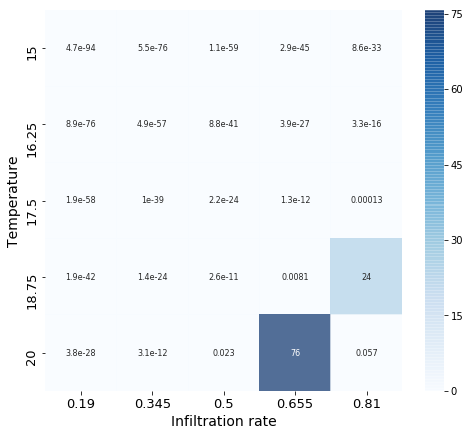

In [76]:
plotHeatMaps(objects['1094SH'], '2015')